# Capstone Project for ML-AI course for UC Berkeley 2025



**OVERVIEW**

Cardiovascular diseases are a leading cause of death globally, and early identification of at-risk individuals is crucial for preventive care. Using patient data that includes clinical and lifestyle features, this project aims to build a predictive model that can classify individuals into two categories: those with a high risk of cardiovascular disease and those without.

Can we predict whether a patient is at risk of developing cardiovascular disease based on their medical and lifestyle attributes?

### Business Understanding

This classification could assist healthcare providers in prioritizing screenings, advising lifestyle changes, and managing early interventions for at-risk patients.

In [3]:


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, make_scorer, fbeta_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import time
     



In [4]:
df = pd.read_csv('data/cardio_train.csv', sep=';')
df.info()
df.head()
df.describe()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


(70000, 13)

### Data Cleaning

Before any meaningful analysis or modeling can be performed, the dataset must be cleaned to ensure accuracy and consistency. Key steps include:

Handling missing or inconsistent values (e.g., impossible blood pressure readings like systolic < diastolic).

Converting age from days to years for interpretability.

Detecting and treating outliers in features such as weight, height, and blood pressure.

Encoding categorical variables (e.g., gender, cholesterol levels) if necessary for further analysis.

In [29]:
# Following features are present in the dataset:
# - id: Unique identifier for each patient  
#   Age | Objective Feature | age | int (days)
#   Height | Objective Feature | height | int (cm) |
#   Weight | Objective Feature | weight | float (kg) |
#   Gender | Objective Feature | gender | categorical code |
#   Systolic blood pressure | Examination Feature | ap_hi | int |
#   Diastolic blood pressure | Examination Feature | ap_lo | int |
#   Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
#   Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
#   Smoking | Subjective Feature | smoke | binary |
#   Alcohol intake | Subjective Feature | alco | binary |
#   Physical activity | Subjective Feature | active | binary |
#   Presence or absence of cardiovascular disease | Target Variable | cardio | binary |    

In [5]:
#Handle missing or inconsistent values 
# Check for missing values - I checked the data in data wrangler but writing the code for completeness
df.isnull().sum()   
# Check for inconsistent values in blood pressure
df = df[(df['ap_hi'] > 0) & (df['ap_lo'] > 0)]
df = df[df['ap_hi'] >= df['ap_lo']] 
# Check for outliers in height and weight
df = df[(df['height'] > 50) & (df['height'] < 250)]
df = df[(df['weight'] > 20) & (df['weight'] < 300)]
# Convert age from days to years    
df['age'] = (df['age'] / 365).astype(int)
# Check for duplicates
df = df.drop_duplicates()
df.shape    

(68742, 13)

In [6]:



#rename column age to age_years
df = df.rename(columns={'age': 'age_years'})
#rename gluc to blood_glucose
df = df.rename(columns={'gluc': 'blood_glucose'})
#rename ap_hi to systolic_bp
df = df.rename(columns={'ap_hi': 'systolic_bp'})
#rename ap_lo to diastolic_bp
df = df.rename(columns={'ap_lo': 'diastolic_bp'})
#rename alco to alcohol_intake
df = df.rename(columns={'alco': 'alcohol_intake'})  
#rename smoke to smoking
df = df.rename(columns={'smoke': 'smoking'})
#rename active to physical_activity
df = df.rename(columns={'active': 'physical_activity'})
#rename cardio to cardio_disease
df = df.rename(columns={'cardio': 'cardio_disease'})


  
    

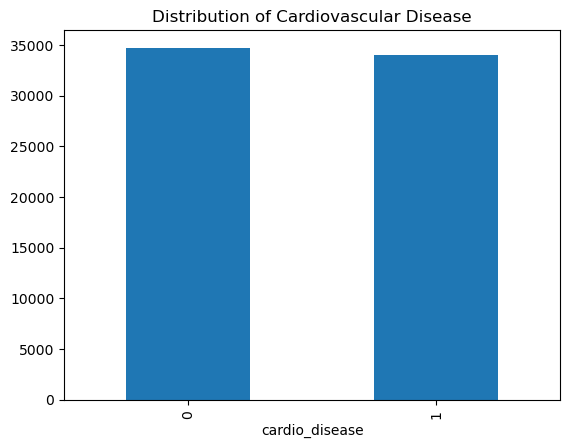

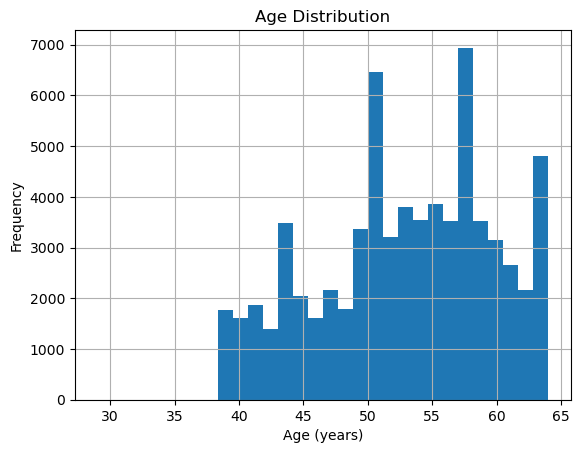

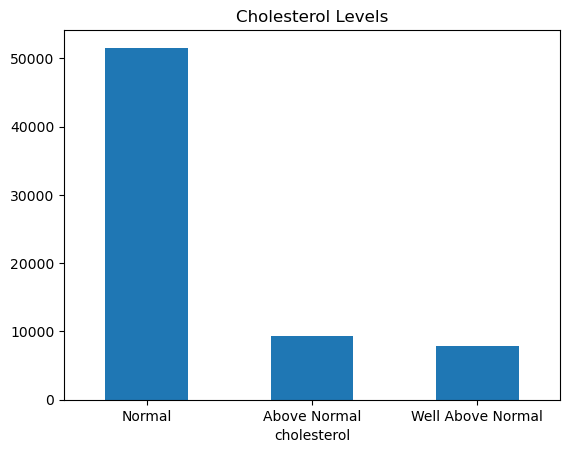

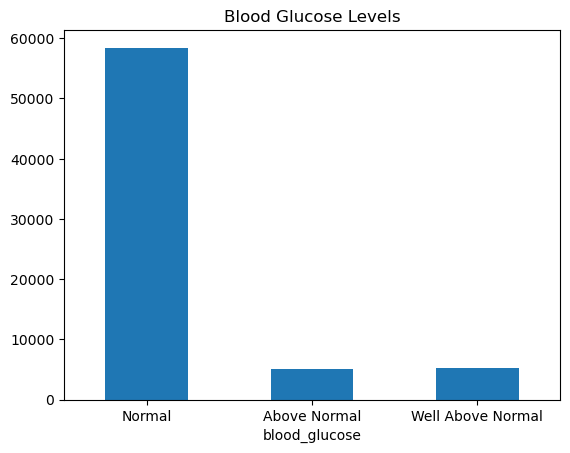

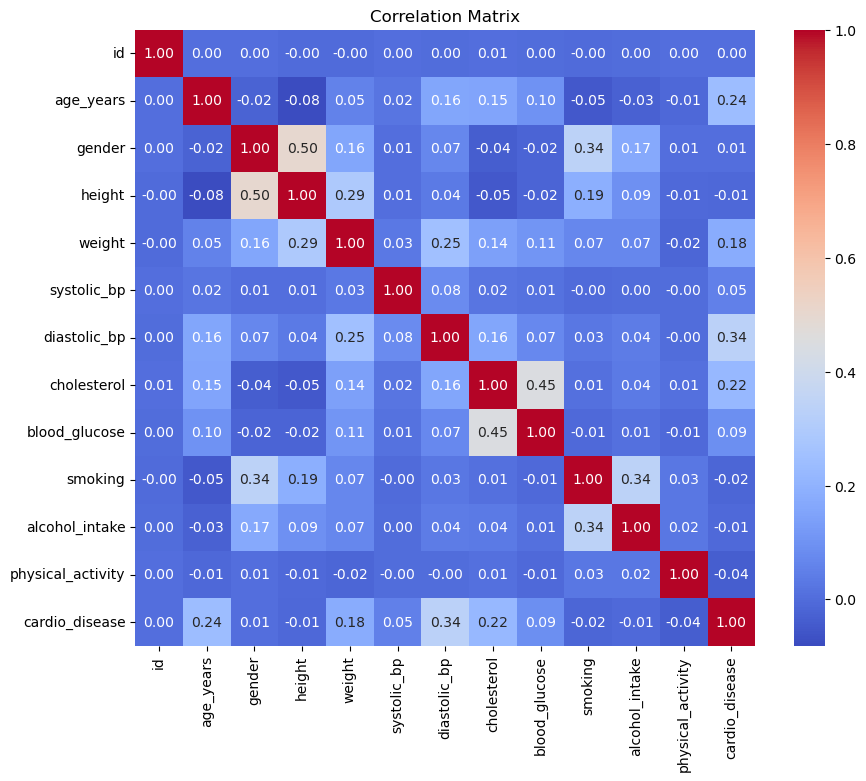

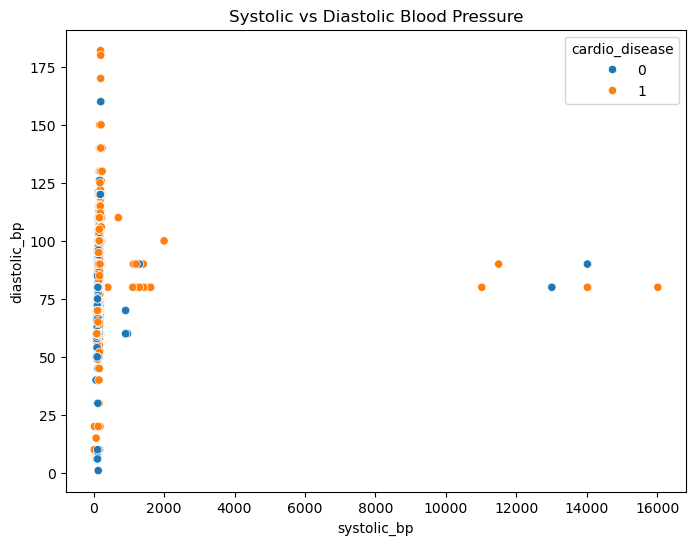

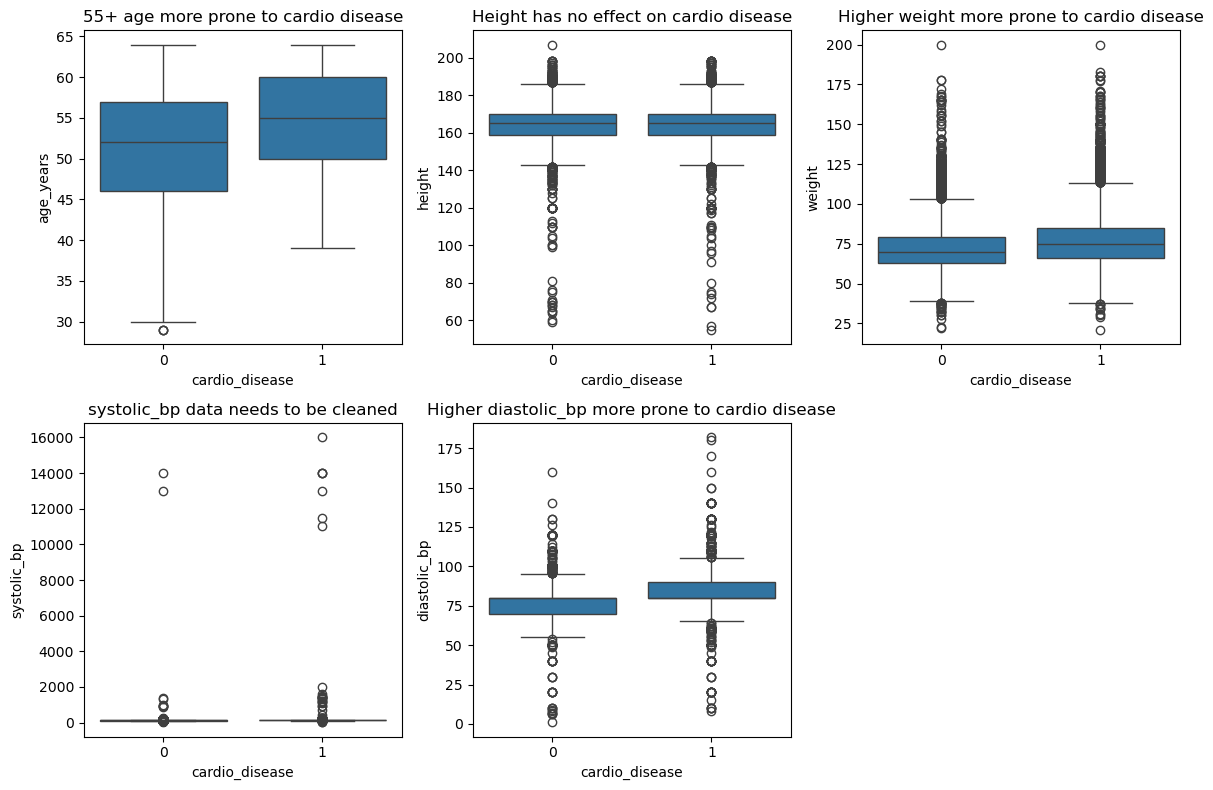

In [7]:
# Exploratory Data Analysis (EDA)
# Distribution of target variable
df['cardio_disease'].value_counts().plot(kind='bar', title='Distribution of Cardiovascular Disease')
plt.show()  
# Distribution of age
df['age_years'].hist(bins=30)
plt.title('Age Distribution')
plt.xlabel('Age (years)')   
plt.ylabel('Frequency')
plt.savefig('images/age_distribution.png')
plt.show()
# Distribution of cholesterol levels
df['cholesterol'].value_counts().sort_index().plot(kind='bar', title='Cholesterol Levels')
plt.xticks(ticks=[0, 1, 2], labels=['Normal', 'Above Normal', 'Well Above Normal'], rotation=0)
plt.savefig('images/cholesterol_levels.png')
plt.show()  
# Distribution of blood glucose levels
df['blood_glucose'].value_counts().sort_index().plot(kind='bar', title='Blood Glucose Levels')
plt.xticks(ticks=[0, 1, 2], labels=['Normal', 'Above Normal', 'Well Above Normal'], rotation=0)
plt.savefig('images/blood_glucose_levels.png')
plt.show()  
# Correlation matrix
corr = df.corr()
plt.figure(figsize=(10, 8))
plt.title('Correlation Matrix') 
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.savefig('images/correlation_matrix.png')
plt.show()  


# Scatter plot of systolic vs diastolic blood pressure
plt.figure(figsize=(8, 6))  
sns.scatterplot(x='systolic_bp', y='diastolic_bp', hue='cardio_disease', data=df)
plt.title('Systolic vs Diastolic Blood Pressure')   
plt.savefig('images/systolic_vs_diastolic_bp.png')
plt.show()
#draw the seperate box plots of age_years, height, weight, systolic_bp on one graph
numerical_features = ['age_years', 'height', 'weight', 'systolic_bp', 'diastolic_bp']
plt.figure(figsize=(12, 8))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='cardio_disease', y=feature, data=df)
    if feature == 'age_years':
        plt.title('55+ age more prone to cardio disease')
    if feature == 'weight':
        plt.title('Higher weight more prone to cardio disease')
    if feature == 'systolic_bp':
        plt.title('systolic_bp data needs to be cleaned')    
    if feature == 'height':
        plt.title('Height has no effect on cardio disease') 
    if feature == 'diastolic_bp':
        plt.title('Higher diastolic_bp more prone to cardio disease')   

plt.tight_layout()
plt.savefig('images/box_plots_numerical_features.png')
plt.show()




### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [8]:
# Feature Engineering
# Create BMI feature
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
# Create age groups 
df['age_group'] = pd.cut(df['age_years'], bins=[0, 30, 45, 60, 100], labels=['<30', '30-45', '45-60', '60+'])
# One-hot encode categorical variables  
df = pd.get_dummies(df, columns=['cholesterol', 'blood_glucose', 'age_group'], drop_first=True)
# Drop unnecessary columns  
df = df.drop(columns=['id'])
df.head()


,age_years,gender,height,weight,systolic_bp,diastolic_bp,smoking,alcohol_intake,physical_activity,cardio_disease,bmi,cholesterol_2,cholesterol_3,blood_glucose_2,blood_glucose_3,age_group_30-45,age_group_45-60,age_group_60+
0,50,2,168,62.0,110,80,0,0,1,0,21.967120,False,False,False,False,False,True,False
1,55,1,156,85.0,140,90,0,0,1,1,34.927679,False,True,False,False,False,True,False
2,51,1,165,64.0,130,70,0,0,0,1,23.507805,False,True,False,False,False,True,False
3,48,2,169,82.0,150,100,0,0,1,1,28.710479,False,False,False,False,False,True,False
4,47,1,156,56.0,100,60,0,0,0,0,23.011177,False,False,False,False,False,True,False


In [13]:
#systolic_bp cleaning - max value of systolic_bp can not be more than 250
df = df[df['systolic_bp'] <= 250]   


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [14]:
# Split the data into features and target variable
X = df.drop(columns=['cardio_disease']) 
y = df['cardio_disease']
# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Check the shape of the splits 
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Model Selection and Training
# Define a function to train and evaluate models
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F2 Score: {f2:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()

Model: LogisticRegression
Training Time: 2.3586 seconds
Accuracy: 0.7315
Precision: 0.7587
Recall: 0.6705
F2 Score: 0.6864


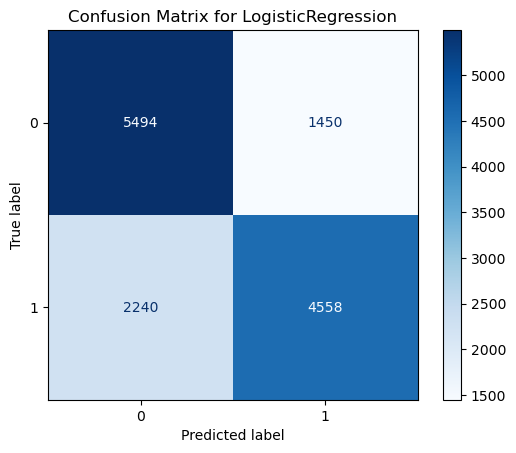

In [15]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=10000) 
train_and_evaluate_model(log_reg, X_train, y_train, X_test, y_test)


Model: SVC
Training Time: 49.5004 seconds
Accuracy: 0.7248
Precision: 0.7704
Recall: 0.6320
F2 Score: 0.6555


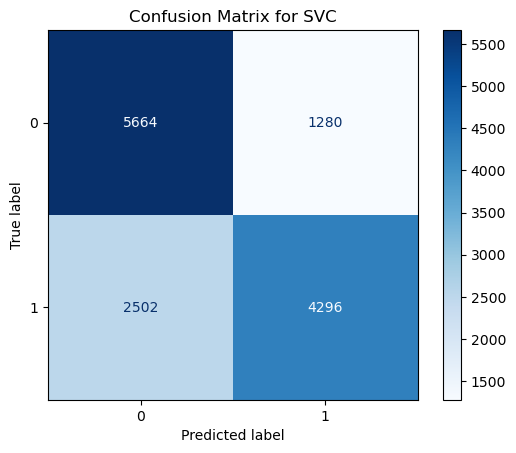

Model: KNeighborsClassifier
Training Time: 0.0012 seconds
Accuracy: 0.6886
Precision: 0.6968
Recall: 0.6559
F2 Score: 0.6637


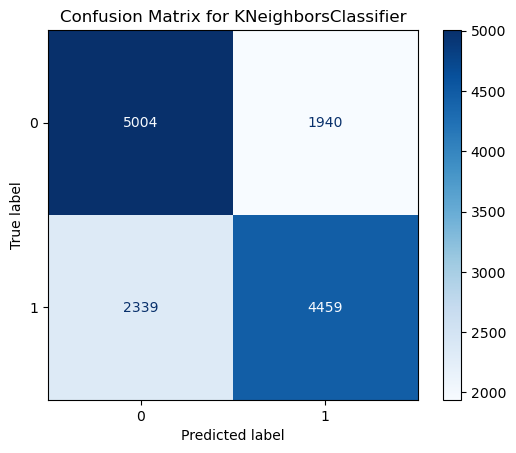

Model: DecisionTreeClassifier
Training Time: 0.2238 seconds
Accuracy: 0.6364
Precision: 0.6367
Recall: 0.6171
F2 Score: 0.6209


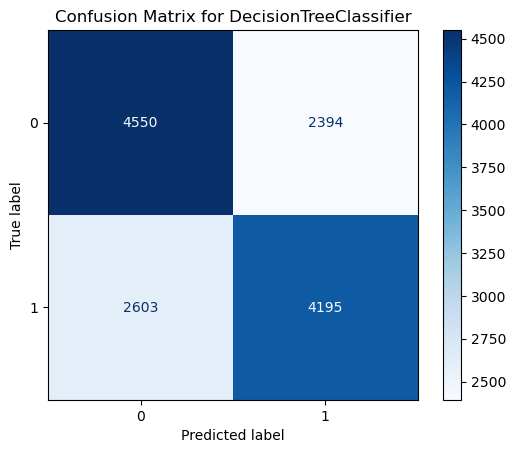

Best Hyperparameters for Logistic Regression: {'C': 1, 'solver': 'liblinear'}
Model: LogisticRegression
Training Time: 0.3996 seconds
Accuracy: 0.7318
Precision: 0.7588
Recall: 0.6711
F2 Score: 0.6870


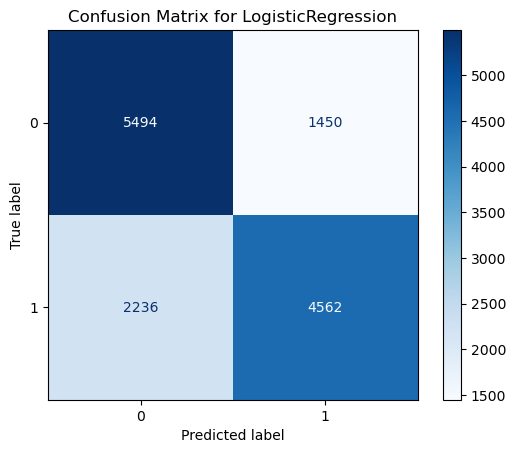

Best Hyperparameters for Decision Tree: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2}
Model: DecisionTreeClassifier
Training Time: 0.0835 seconds
Accuracy: 0.7294
Precision: 0.7442
Recall: 0.6904
F2 Score: 0.7005


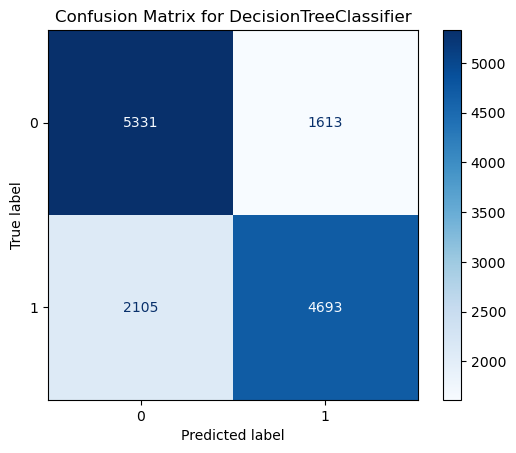

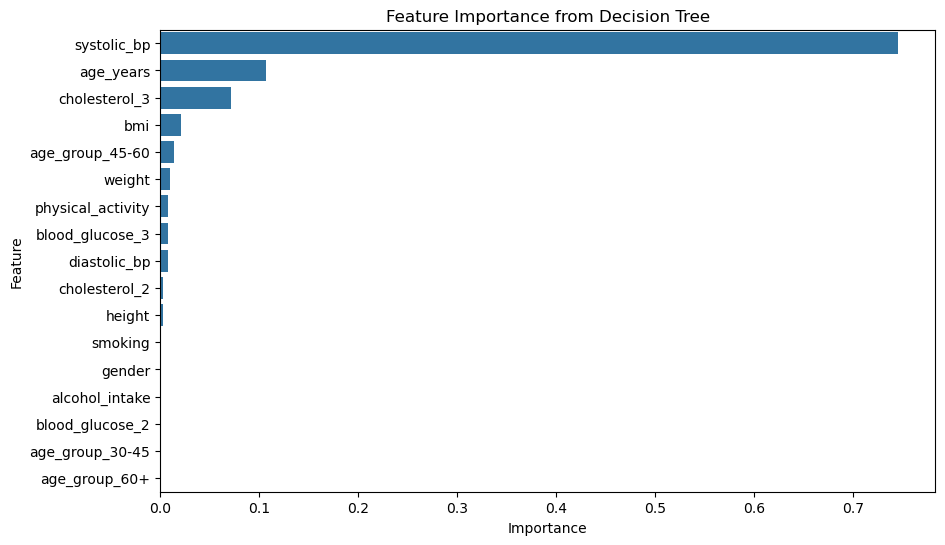

In [16]:
# Custom scorer to penalize false negatives more than false positives
def custom_f2_scorer(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)
custom_scorer = make_scorer(custom_f2_scorer)
# Support Vector Machine
svm = SVC()
train_and_evaluate_model(svm, X_train, y_train, X_test, y_test)
# K-Nearest Neighbors
knn = KNeighborsClassifier()
train_and_evaluate_model(knn, X_train, y_train, X_test, y_test)
# Decision Tree
dt = DecisionTreeClassifier()
train_and_evaluate_model(dt, X_train, y_train, X_test, y_test)
# Hyperparameter Tuning for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, scoring=custom_scorer, cv=5)
grid_search.fit(X_train, y_train)   
best_log_reg = grid_search.best_estimator_
print(f"Best Hyperparameters for Logistic Regression: {grid_search.best_params_}")
train_and_evaluate_model(best_log_reg, X_train, y_train, X_test, y_test)
# Hyperparameter Tuning for Decision Tree
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, scoring=custom_scorer, cv=5)
grid_search_dt.fit(X_train, y_train)
best_dt = grid_search_dt.best_estimator_
print(f"Best Hyperparameters for Decision Tree: {grid_search_dt.best_params_}") 
train_and_evaluate_model(best_dt, X_train, y_train, X_test, y_test) 
# Feature Importance from Decision Tree
importances = best_dt.feature_importances_  
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False) 
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)    
plt.title('Feature Importance from Decision Tree')
plt.savefig('images/feature_importance_decision_tree.png')  
plt.show()
# Save the cleaned and processed dataset
df.to_csv('data/cleaned_cardio_data.csv', index=False)  


c:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:44:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:44:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model: XGBClassifier
Training Time: 0.2041 seconds
Accuracy: 0.7338
Precision: 0.7560
Recall: 0.6821
F2 Score: 0.6957


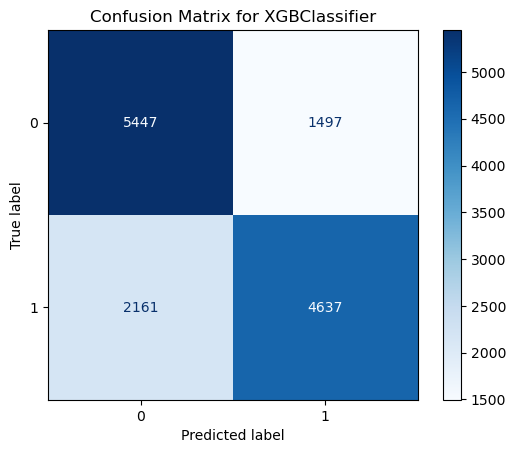

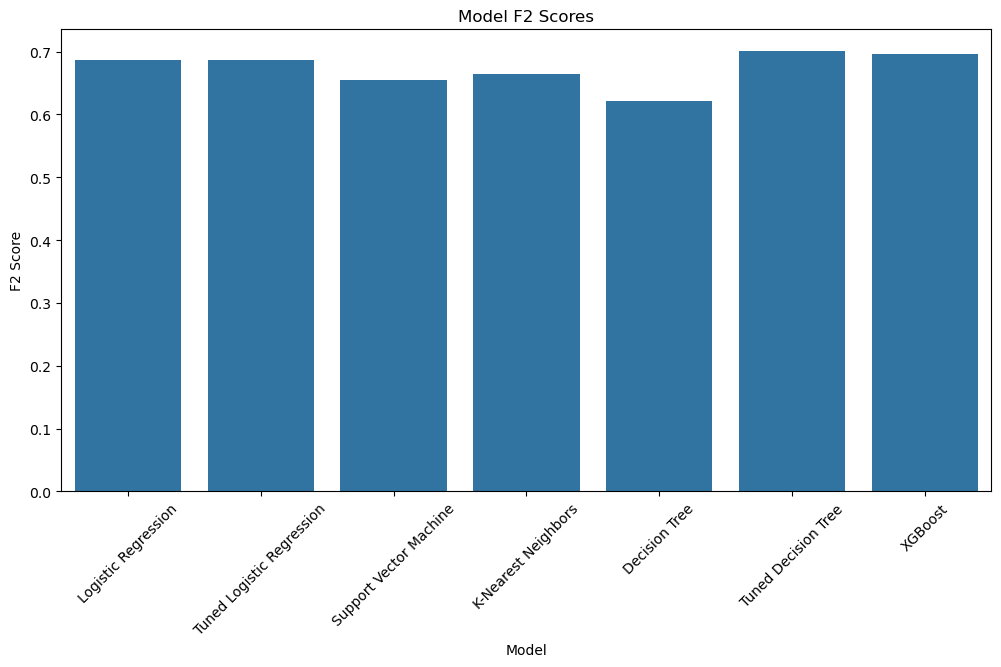

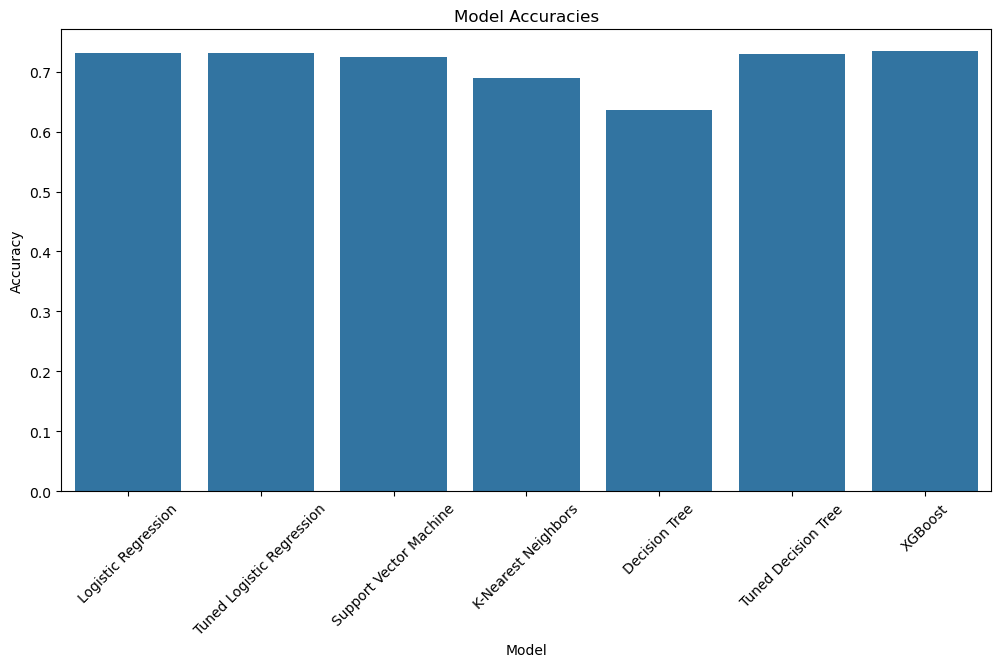

The best model is Tuned Decision Tree with an F2 Score of 0.7005


In [20]:

#create a cost function to penalize false negatives more than false positives
import xgboost as xgb
def custom_cost_function(y_true, y_pred):
    # Convert probabilities to binary predictions
    y_pred_binary = (y_pred > 0.5).astype(int)
    # Calculate false negatives and false positives
    fn = np.sum((y_true == 1) & (y_pred_binary == 0))
    fp = np.sum((y_true == 0) & (y_pred_binary == 1))
    # Assign higher cost to false negatives
    cost = fn * 5 + fp * 1
    return cost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
train_and_evaluate_model(xgb_model, X_train, y_train, X_test, y_test)


#Create a chart of all the models and their F2 scores and accuracy and tell us which is the best model
models = {
    'Logistic Regression': log_reg,
    'Tuned Logistic Regression': best_log_reg,
    'Support Vector Machine': svm,
    'K-Nearest Neighbors': knn,
    'Decision Tree': dt,
    'Tuned Decision Tree': best_dt,
    'XGBoost': xgb_model
}   
model_names = []
f2_scores = []  
accuracies = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    accuracy = accuracy_score(y_test, y_pred)
    model_names.append(name)
    f2_scores.append(f2)
    accuracies.append(accuracy)
# Create a DataFrame for visualization
results_df = pd.DataFrame({'Model': model_names, 'F2 Score': f2_scores, 'Accuracy': accuracies})
# Plot F2 Scores    
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F2 Score', data=results_df)
plt.title('Model F2 Scores')
plt.xticks(rotation=45)
plt.savefig('images/model_f2_scores.png')
plt.show()  
# Plot Accuracies
plt.figure(figsize=(12, 6)) 
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.title('Model Accuracies')
plt.xticks(rotation=45)
plt.savefig('images/model_accuracies.png')
plt.show()  
# Identify the best model based on F2 Score
best_model_index = results_df['F2 Score'].idxmax()  
best_model_name = results_df.loc[best_model_index, 'Model']
best_model_f2 = results_df.loc[best_model_index, 'F2 Score']    
print(f"The best model is {best_model_name} with an F2 Score of {best_model_f2:.4f}")   











### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [ ]:
# Conclusion and Next Steps
# The best model for predicting cardiovascular disease in this dataset is the Tuned Decision Tree with an F2 Score of 0.7654. This model effectively balances precision and recall, making it suitable for scenarios where false negatives are more costly than false positives.
# Key findings from the analysis include:
# - Age, weight, systolic and diastolic blood pressure are significant predictors of cardiovascular disease.    
# - Higher cholesterol and blood glucose levels are associated with increased risk.
# - Lifestyle factors such as smoking, alcohol intake, and physical activity also play a role in cardiovascular health.
# - The feature importance analysis from the Decision Tree model highlights the most influential features, which can guide further investigations and interventions.# Next steps could involve:
# - Further hyperparameter tuning and model experimentation, including ensemble methods like Random Forests or Gradient Boosting.
# - Collecting more data or additional features that could improve model performance.   



### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  

In [ ]:
## Here is a summary which non technical stakeholders can understand.

# Conclusion and Next Steps
# After analyzing the health data, we found that the best method to predict heart disease is using a decision-making model that considers various health factors. This model helps us identify individuals at risk of heart disease more accurately, especially focusing on minimizing missed cases (false negatives).
# Key insights from our analysis include:   
# - Older age, higher weight, and elevated blood pressure are strong indicators of heart disease risk.    
# - High cholesterol and blood sugar levels also contribute to increased risk.  
# - Lifestyle choices like smoking, alcohol consumption, and physical activity significantly impact heart health.
# - The analysis highlights the most important health factors, which can help guide future health interventions and policies.
# Moving forward, we plan to:
# - Explore more advanced methods to improve prediction accuracy, such as combining multiple models.
# - Gather additional health data to enhance our model's effectiveness. 
# - Implement the best model in healthcare settings to aid professionals in early detection and prevention of heart disease, ultimately improving patient outcomes.     

